##### importing libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### loading data, reshaping, onehot encoding of labels

In [7]:
def load_data():
    xtrain,ytrain = loadlocal_mnist(images_path = "train-images-idx3-ubyte",labels_path = 'train-labels-idx1-ubyte')
    xtest,ytest = loadlocal_mnist(images_path = 't10k-images-idx3-ubyte',labels_path = 't10k-labels-idx1-ubyte')
    xtrain=xtrain.reshape(xtrain.shape[0],28,28,1)
    xtest=xtest.reshape(xtest.shape[0],28,28,1)
    # compute the number of labels
    num_labels = np.amax(ytrain) + 1
    #print(num_labels)
    # convert to one-hot vector
    ytrain = np.eye(num_labels)[ytrain.astype('int32')]
    ytest = np.eye(num_labels)[ytest.astype('int32')]
    #print(ytrain.shape,ytest.shape)
    return xtrain,ytrain,xtest,ytest

#### function for displaying images

In [27]:
def display(x,y):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    xp=x.reshape(x.shape[0],28,28)
    a=[np.where(r==1)[0][0] for r in y]
    plt.figure(figsize=(15,15))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(xp[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[a[i]])
    plt.show()

## data augmentation of 10k images and concatenation

In [28]:
xtrain,ytrain,xtest,ytest=load_data()
def transform(x,y): 
    transform_size=10000
    datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.05, 
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True, 
        data_format="channels_last",
        zca_whitening=True)
    # fit data for zca whitening
    datagen.fit(x)
    #image_generator.fit(y_train, augment=True)
    # get transformed images
    randidx = np.random.randint(x.shape[0], size=transform_size)
    xaug = x[randidx].copy()
    yaug = y[randidx].copy()
    xaug = datagen.flow(xaug, np.zeros(transform_size),
                                batch_size=transform_size, shuffle=False).next()[0]
    # append augmented data to trainset
    display(xaug,yaug)
    plt.show()
    x = np.concatenate((x, xaug))
    y = np.concatenate((y, yaug))
    return x,y

def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :, :, :]
    shuffled_y = y[permutation,:]
    return shuffled_x, shuffled_y

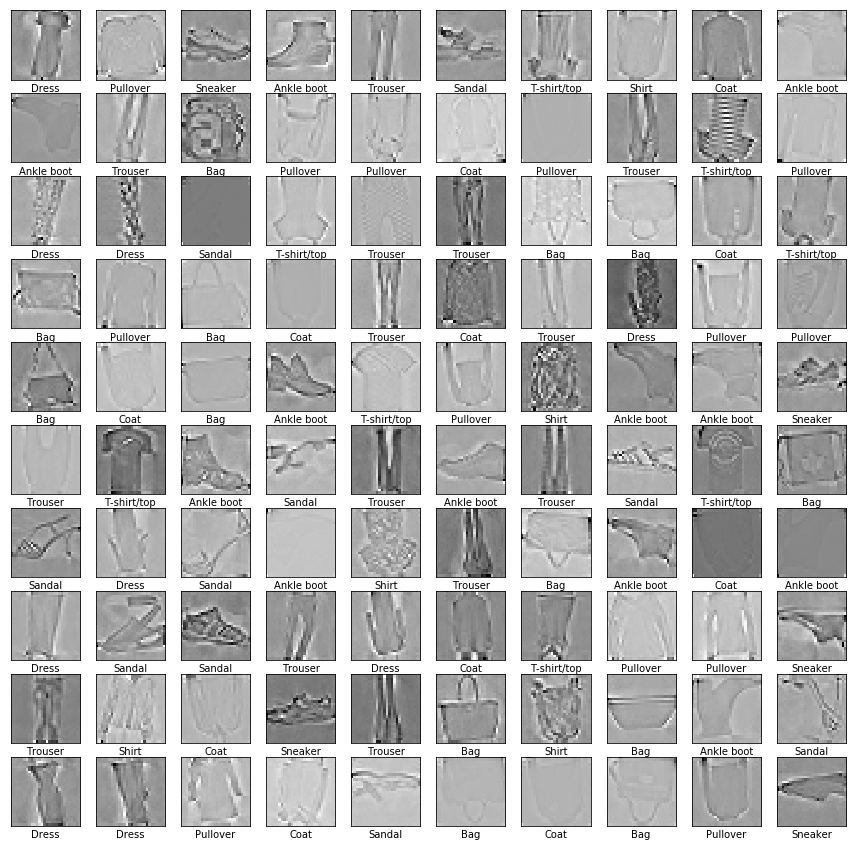

In [29]:
xtrain,ytrain=randomize(xtrain,ytrain)
xtrain,ytrain=transform(xtrain,ytrain)

#### randominising the added images

#### scaling and spliting the data

In [30]:
# we train our network using float data
xtrain = xtrain.astype('float32') / 255
xtest = xtest.astype('float32') / 255

xtrain,xvalid,ytrain,yvalid=train_test_split(xtrain,ytrain,test_size=0.02,random_state=42)

#### def funcs for weights bias conv_layer maxpool fc

In [8]:
# weight and bais wrappers

def weight_variable(shape):
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W',
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)
def bias_variable(shape):
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                           dtype=tf.float32,
                           initializer=initial)
def conv_layer(x, filter_size, num_filters, stride, name,batch_norm=False,drop_out=False):
    with tf.variable_scope(name):
        num_in_channel = x.get_shape().as_list()[-1]
        shape = [filter_size, filter_size, num_in_channel, num_filters]
        W = weight_variable(shape=shape)
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_filters])
        tf.summary.histogram('bias', b)
        layer = tf.nn.conv2d(x, W,
                             strides=[1, stride, stride, 1],
                             padding="SAME")
        
        layer += b
        
        
        if(batch_norm):
            layer = tf.layers.batch_normalization(layer)
        layer = tf.nn.relu(layer)
        if(drop_out):
            layer = tf.layers.dropout(layer,rate=0.5)
        return layer
    
def max_pool(x, ksize, stride, name):
    return tf.nn.max_pool(x,
                          ksize=[1, ksize, ksize, 1],
                          strides=[1, stride, stride, 1],
                          padding="SAME",
                          name=name)
def flatten_layer(layer):
    with tf.variable_scope('Flatten_layer'):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

def fc_layer(x, num_units, name, use_relu=True):
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(shape=[in_dim, num_units])
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_units])
        tf.summary.histogram('bias', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer

#### defining variables

In [9]:
img_h = img_w = 28  # MNIST images are 28x28
img_size_flat = img_h * img_w  # 28x28=784, the total number of pixels
n_classes = 10  # Number of classes, one class per digit
n_channels = 1
# 1st Convolutional Layer
filter_size1 = 3  # Convolution filters are 5 x 5 pixels.
num_filters1 = 16  # There are 16 of these filters.
stride1 = 1  # The stride of the sliding window

# 2nd Convolutional Layer
filter_size2 = 3  # Convolution filters are 5 x 5 pixels.
num_filters2 = 32  # There are 32 of these filters.
stride2 = 1  # The stride of the sliding window

# Fully-connected layer.
h1 = 128  # Number of neurons in fully-connected layer.

In [10]:
tf.reset_default_graph()

#### defining input for nn

In [165]:
with tf.name_scope('Input'):
    x = tf.placeholder(tf.float32, shape=[None, img_h, img_w, n_channels], name='X')
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

### defining layers

In [166]:
conv1 = conv_layer(x, filter_size1, num_filters1, stride1, name='conv1',batch_norm=True,drop_out=True)
conv2 = conv_layer(conv1, filter_size2, num_filters2, stride2, name='conv2',batch_norm=True,drop_out=False)
#pool1 = max_pool(conv2, ksize=2, stride=2, name='pool1')
conv3 = conv_layer(conv2, filter_size1, num_filters1, stride1, name='conv3',batch_norm=True,drop_out=False)

#conv4 = conv_layer(conv3, filter_size2, num_filters2, stride2, name='conv4',batch_norm=True,drop_out=False)
pool2 = max_pool(conv3, ksize=2, stride=2, name='pool2')

layer_flat = flatten_layer(pool2)
fc1 = fc_layer(layer_flat, h1, 'FC1', use_relu=True)
output_logits = fc_layer(fc1, n_classes, 'OUT', use_relu=False)

### storing path and learning rate

In [167]:
logs_path = "./logs"  # path to the folder that we want to save the logs for Tensorboard
lr = 0.001  # The optimization initial learning rate

In [168]:
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
    tf.summary.scalar('loss', loss)
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam-op').minimize(loss)
    with tf.variable_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf.summary.scalar('accuracy', accuracy)
    with tf.variable_scope('Prediction'):
        cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

In [169]:
def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

In [170]:
# Initialize the variables
init = tf.global_variables_initializer()
# Merge all summaries
merged = tf.summary.merge_all()

In [171]:
epochs = 50  # Total number of training epochs
batch_size = 100  # Training batch size
display_freq = 100  # Frequency of displaying the training results
loss_n=0.45

In [172]:
sess = tf.InteractiveSession()
sess.run(init)
global_step = 0
summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
acc_valid_p=0
stop=5
counter=0
#Create a saver object which will save all the variables
saver = tf.train.Saver()
# Number of training iterations in each epoch
num_tr_iter = int(len(ytrain) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    
    #x_train, y_train = randomize(xtrain, ytrain)
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(xtrain, ytrain, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch, summary_tr = sess.run([loss, accuracy, merged],
                                                         feed_dict=feed_dict_batch)
            summary_writer.add_summary(summary_tr, global_step)
            print(global_step)
            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

            
        if loss_batch<loss_n:
            lr=lr*0.1
            loss_n-=0.05
            print("lr is changed", lr)
            
            
     # Run validation after every epoch
    feed_dict_valid = {x: xvalid, y: yvalid}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')
    #lr = 0.01
#     if loss_p>loss_valid:
#         loss_p=loss_valid
#         counter_loss=0
#     elif:
#         if loss_p-loss_valid<0.5:
#             lr=0.001
#             print("lr is changed to 0.001")
#             counter_loss+=1
#         if loss_p-loss_valid<0.2:
#             lr=0.0001
#             print("lr is changed to 0.0001")
    
        
    if epoch>4:
        if acc_valid_p<acc_valid:
            counter=0
            acc_valid_p=acc_valid
            saved_path = saver.save(sess, './saved_variable')
            print('model saved in {}'.format(saved_path))
        elif counter<stop:
            counter+=1
        else:
            print("Early stopping")
            break
    else:
        pass
            
        

Training epoch: 1
iter   0:	 Loss=2.30,	Training Accuracy=15.0%
iter 100:	 Loss=1.11,	Training Accuracy=59.0%
iter 200:	 Loss=0.84,	Training Accuracy=71.0%
iter 300:	 Loss=0.79,	Training Accuracy=68.0%
iter 400:	 Loss=0.69,	Training Accuracy=75.0%
iter 500:	 Loss=0.88,	Training Accuracy=72.0%
iter 600:	 Loss=0.69,	Training Accuracy=79.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.73, validation accuracy: 72.9%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.67,	Training Accuracy=76.0%
iter 100:	 Loss=0.83,	Training Accuracy=67.0%
iter 200:	 Loss=0.63,	Training Accuracy=77.0%
iter 300:	 Loss=0.45,	Training Accuracy=86.0%
lr is changed 0.0001
iter 400:	 Loss=0.36,	Training Accuracy=89.0%
lr is changed 1e-05
iter 500:	 Loss=0.61,	Training Accuracy=78.0%
iter 600:	 Loss=0.37,	Training Accuracy=90.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.47, validation a

In [ ]:
# Test the network when training is done
x_test, y_test = xtest,ytest
feed_dict_test = {x: x_test, y: y_test}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

In [ ]:
tf.reset_default_graph()
imported_graph = tf.train.import_meta_graph('saved_variable.meta')
with tf.Session() as sess:
    imported_graph.restore(sess, './saved_variable')
     
    # print the loaded variable
    # Test the network when training is done
    x_test, y_test = xtest,ytest
    print(x_test.shape, y_test.shape)
    feed_dict_test = {'Input/X:0': x_test, 'Input/Y:0': y_test}
    loss_test, acc_test = sess.run(['Train/Loss/loss:0', 'Train/Accuracy/accuracy:0'], feed_dict=feed_dict_test)
    print('---------------------------------------------------------')
    print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
    print('---------------------------------------------------------')


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./saved_variable
(10000, 28, 28, 1) (10000, 10)


In [ ]:
# for i in  tf.get_default_graph().get_operations():
#     print(i.name,i.values())